# Using a feature representation learned for signature images

This notebook contains code to pre-process signature images and to obtain feature-vectors using the learned feature representation on the GPDS dataset

In [1]:
import numpy as np

# Functions to load and pre-process the images:
from scipy.misc import imread, imsave
from preprocess.normalize import normalize_image, resize_image, crop_center, preprocess_signature

# Functions to load the CNN model
import signet
from cnn_model import CNNModel

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

/Users/adarshsrivastava/pyenv/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Pre-processing a single image

In [2]:
original = imread('data/some_signature.png')

In [3]:
# Manually normalizing the image following the steps provided in the paper.
# These steps are also implemented in preprocess.normalize.preprocess_signature

normalized = 255 - normalize_image(original, size=(952, 1360))
resized = resize_image(normalized, (170, 242))
cropped = crop_center(resized, (150,220))


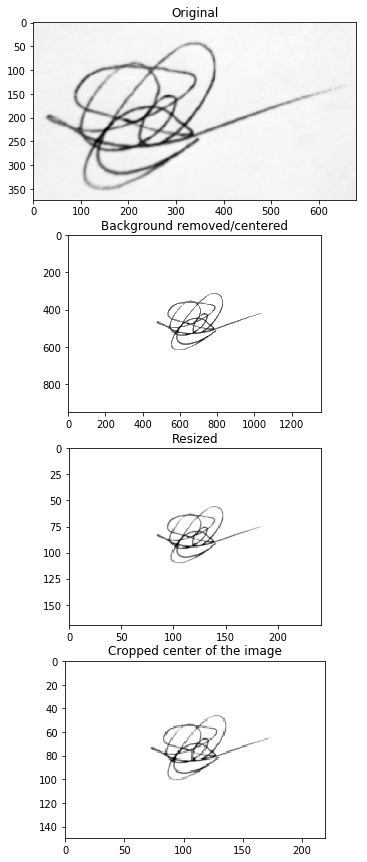

In [4]:
# Visualizing the intermediate steps

f, ax = plt.subplots(4,1, figsize=(6,15))
ax[0].imshow(original, cmap='Greys_r')
ax[1].imshow(normalized)
ax[2].imshow(resized)
ax[3].imshow(cropped)

ax[0].set_title('Original')
ax[1].set_title('Background removed/centered')
ax[2].set_title('Resized')
ax[3].set_title('Cropped center of the image')

## Processing multiple images and obtaining feature vectors

In [5]:
user1_sigs  = [imread('data/a%d.png' % i) for i in  [1,2]]
user2_sigs  = [imread('data/b%d.png' % i) for i in  [1,2]]

canvas_size = (952, 1360)

processed_user1_sigs = np.array([preprocess_signature(sig, canvas_size) for sig in user1_sigs])
processed_user2_sigs = np.array([preprocess_signature(sig, canvas_size) for sig in user2_sigs])

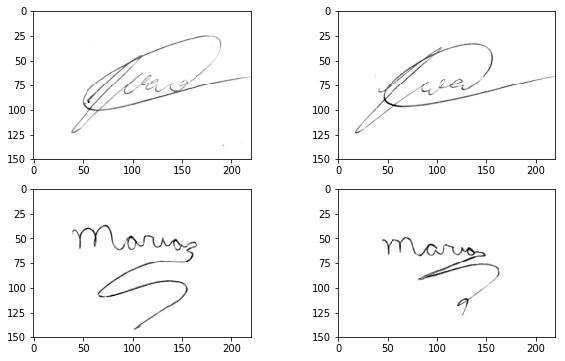

In [6]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,2, figsize=(10,6))
ax[0,0].imshow(processed_user1_sigs[0])
ax[0,1].imshow(processed_user1_sigs[1])

ax[1,0].imshow(processed_user2_sigs[0])
ax[1,1].imshow(processed_user2_sigs[1])

### Using the CNN to obtain the feature representations

In [21]:
# Path to the learned weights
model_weight_path = 'models/signet.pkl'

In [22]:
# Instantiate the model
model = CNNModel(signet, model_weight_path)

In [23]:
# Obtain the features. Note that you can process multiple images at the same time

user1_features = model.get_feature_vector_multiple(processed_user1_sigs, layer='fc2')
user2_features = model.get_feature_vector_multiple(processed_user2_sigs, layer='fc2')

### Inspecting the learned features

The feature vectors have size 2048:

In [24]:
user1_features.shape
print user1_features

[[ 0.4958187   0.005479    1.17305375 ...,  0.          1.71497365
   0.5047121 ]
 [ 0.03960701  0.          0.43979587 ...,  0.21319782  1.27314107
   0.11370932]]


In [25]:
print('Euclidean distance between signatures from the same user')
print(np.linalg.norm(user1_features[0] - user1_features[1]))
print(np.linalg.norm(user2_features[0] - user2_features[1]))

Euclidean distance between signatures from the same user
19.4466726411
20.1104556659


In [26]:
print('Euclidean distance between signatures from different users')

dists = [np.linalg.norm(u1 - u2) for u1 in user1_features for u2 in user2_features]
print(dists)

Euclidean distance between signatures from different users
[34.486360506837514, 38.478013713814761, 31.770298948003848, 34.436212525052973]


In [27]:
# Other models:
# model_weight_path = 'models/signetf_lambda0.95.pkl'
# model_weight_path = 'models/signetf_lambda0.999.pkl'